# Demand Forecast: Time Series Analysis

Forecasting demand for a restaurant is crucial for effective inventory management, staff scheduling, and overall operational efficiency. Time series forecasting methods can help predict future demand based on historical data. 

We aim to apply various machine learning methods in this task and then identify the most suitable approach. Each method has its strengths and weaknesses, and the choice depends on factors such as data characteristics, level of accuracy required, computational resources, and ease of implementation. Experimenting with multiple methods and evaluating their performance using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) can help identify the most suitable approach for forecasting restaurant demand.

Methods include:
1. Autoregressive Integrated Moving Average (ARIMA)
2. Extreme Gradient Boosting (XGBoost)
3. Random Forest
(to be finalized)

## 1. Daily Visit Data Prediction

### 1.1 ARIMA Model

In [130]:
#import necessary libraries
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from skopt import gp_minimize
from skopt.space import Real, Integer

In [161]:
df_synthetic = pd.read_csv("../data/raw/synthetic_visit_data.csv")
df_synthetic.head()

,day_of_week,visit_date,visitors
0,Sunday,2023-01-01,409
1,Monday,2023-01-02,276
2,Tuesday,2023-01-03,158
3,Wednesday,2023-01-04,118
4,Thursday,2023-01-05,110


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


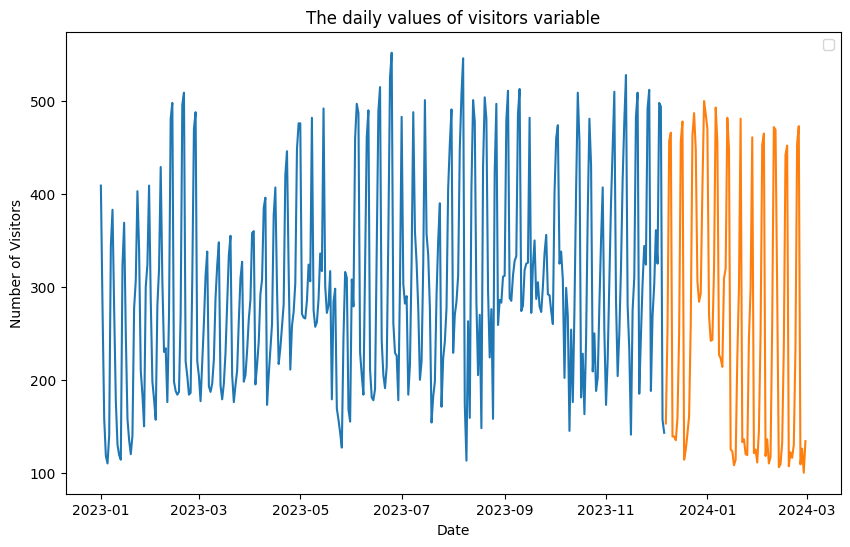

In [162]:
df_synthetic['visit_date'] = pd.to_datetime(df_synthetic['visit_date'])
df_synthetic.set_index('visit_date', inplace=True)

# Split the data into training and testing sets
train_percent = 0.8  # Use 80% of the data for training
split_index = int(len(df_synthetic) * train_percent)
train_data = df_synthetic.iloc[:split_index]
test_data = df_synthetic.iloc[split_index:]

plt.figure(figsize=(10, 6))
plt.plot(train_data['visitors'])
plt.plot(test_data['visitors'])
plt.title('The daily values of visitors variable')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.show()

In [163]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
        

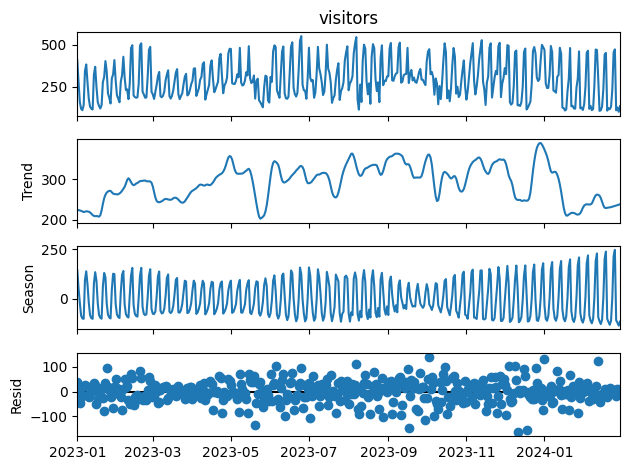

In [165]:
## Seasonal Decomposition (using STL)
from statsmodels.tsa.seasonal import STL
stl = STL(df_synthetic['visitors'], seasonal=13)
result = stl.fit()
result.plot()
plt.show()

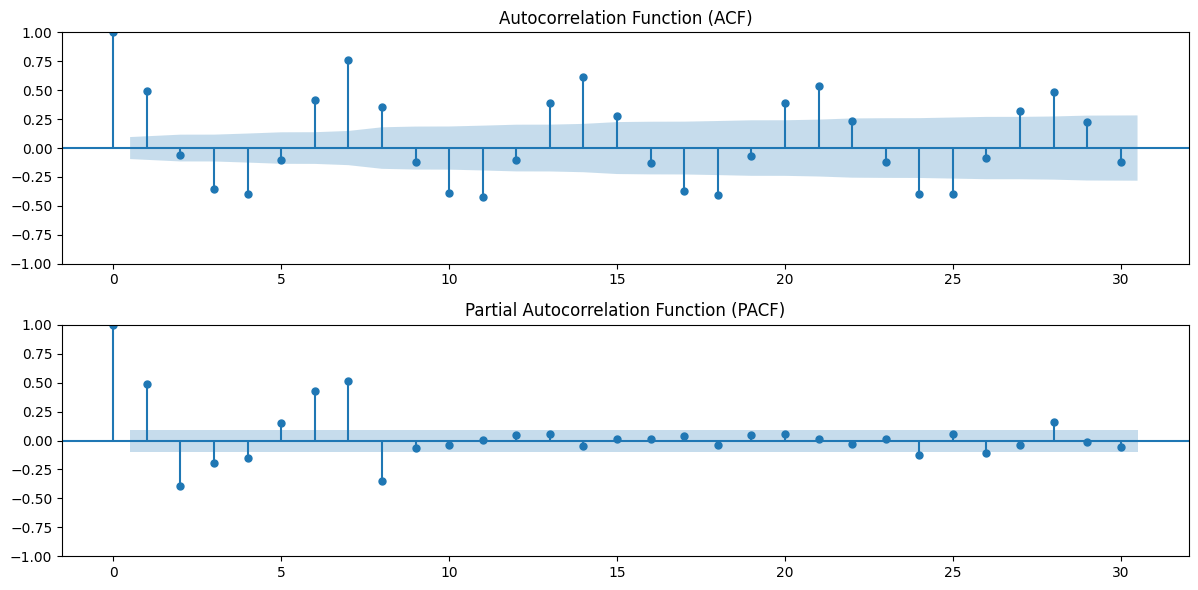

In [164]:
## finding order parameters (p,d,q)

# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df_synthetic['visitors'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# plot PACF
plt.subplot(2, 1, 2)
plot_pacf(df_synthetic['visitors'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [127]:
# Grid search for finding potential order parameters
# Define ranges for p, d, and q
p_range = range(0, 10)  # Example range for p
d_range = range(0, 10)  # Example range for d
q_range = range(0, 10)  # Example range for q

# Create a list of all possible combinations of p, d, and q
order_combinations = list(product(p_range, d_range, q_range))

# Define a function to evaluate ARIMA models for a given order (p, d, q)
def evaluate_arima(order, data):
    model = ARIMA(data, order=order)
    try:
        model_fit = model.fit()
        return model_fit.aic, order
    except:
        return None, order

# Evaluate ARIMA models for all order combinations
results = []
for order in order_combinations:
    aic, order_evaluated = evaluate_arima(order, df_synthetic['visitors'])
    if aic is not None:
        results.append((aic, order_evaluated))

# Sort the results by AIC (lower is better)
results.sort()

# Print the best fitting models and their corresponding AIC values
print("Best fitting ARIMA models:")
for result in results[:5]:  # Print top 5 models
    print("AIC:", result[0], "Order:", result[1])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

Best fitting ARIMA models:
AIC: 12.0 Order: (2, 6, 3)
AIC: 12.0 Order: (2, 8, 3)
AIC: 16.0 Order: (2, 9, 5)
AIC: 18.0 Order: (2, 8, 6)
AIC: 20.0 Order: (3, 6, 6)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [131]:
# Define the objective function for Bayesian optimization
def objective_function(params):
    p, d, q = params
    try:
        model = ARIMA(df_synthetic['visitors'], order=(p, d, q))
        model_fit = model.fit()
        # Use AIC as the objective to minimize
        return model_fit.aic
    except:
        # Return a high value if the model fails to fit
        return np.inf

# Define the search space for p, d, and q
search_space = [Integer(0, 3, name='p'),
                Integer(0, 2, name='d'),
                Integer(0, 3, name='q')]

# Perform Bayesian optimization
result = gp_minimize(objective_function, search_space, n_calls=20, random_state=42)

# Get the best parameters
best_params = result.x
best_aic = result.fun

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

Best Parameters: [3, 0, 3]
Best AIC: 4271.196200653769


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               visitors   No. Observations:                  295
Model:                 ARIMA(8, 0, 2)   Log Likelihood               -1640.223
Date:                Wed, 03 Apr 2024   AIC                           3304.446
Time:                        18:07:32   BIC                           3348.690
Sample:                    02-26-2023   HQIC                          3322.163
                         - 12-17-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        305.8693      8.119     37.675      0.000     289.957     321.782
ar.L1          0.7123      0.145      4.901      0.000       0.427       0.997
ar.L2         -0.1199      0.104     -1.154      0.2

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


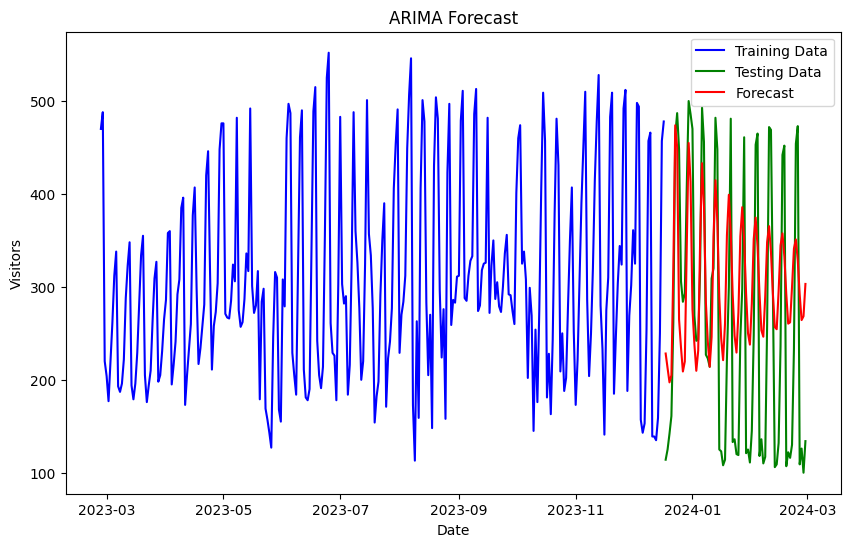

In [143]:
# Define the percentage of data to use for training
train_percent = 0.8  # Use 80% of the data for training

# Calculate the index to split the data
split_index = int(len(df_synthetic) * train_percent)

# Split the data into training and testing sets
train_data = df_synthetic.iloc[:split_index]
test_data = df_synthetic.iloc[split_index:]

# Fit ARIMA model
model = ARIMA(train_data['visitors'], order=(8, 0, 2))  
## parameters need to be adjusted
results = model.fit()

# Summary of the model
print(results.summary())

# Forecast future values
forecast_steps = len(test_data)  # Forecast for the same duration as the testing set
forecast = results.forecast(steps=forecast_steps)  # Corrected line

# Create forecast index
forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq=test_data.index.freq)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['visitors'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['visitors'], label='Testing Data', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')  # Use forecast_index instead of forecast.index
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend()
plt.show()

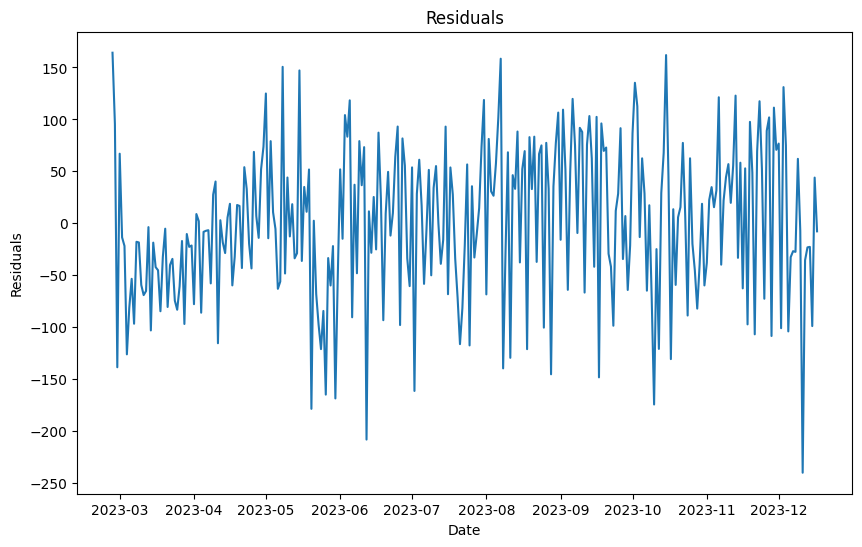

In [135]:

# Plot residuals to check for randomness
plt.figure(figsize=(10, 6))
plt.plot(results.resid)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()


<Figure size 1000x600 with 0 Axes>

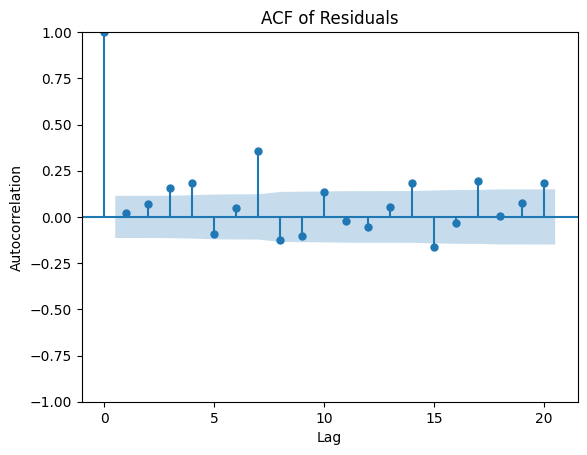

<Figure size 1000x600 with 0 Axes>

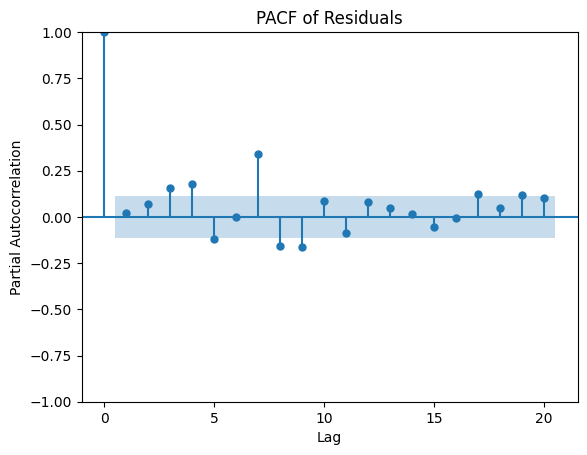

In [136]:
# Plot ACF and PACF of residuals
plt.figure(figsize=(10, 6))
plot_acf(results.resid, lags=20)
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(results.resid, lags=20)
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

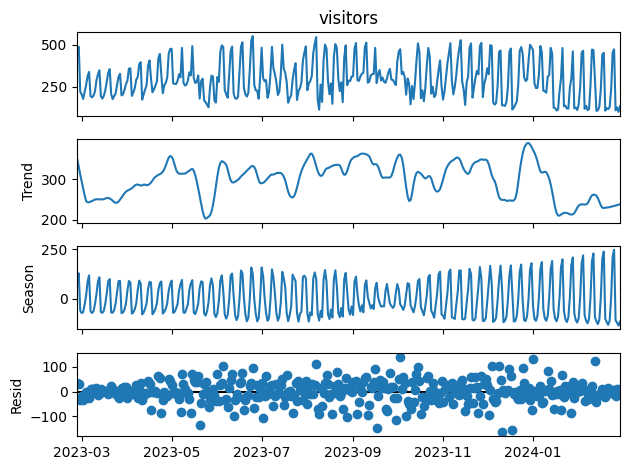

In [10]:
rolling_mean = df_synthetic['visitors'].rolling(window=3).mean()
rolling_std = df_synthetic['visitors'].rolling(window=3).std()


In [11]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(df_synthetic):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = df_synthetic.iloc[train_index], df_synthetic.iloc[test_index]


Train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106] Test: [107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212]
Train: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27 

##  1.2 XGBoost 

Using XGBoost for time series prediction involves framing the problem as a supervised learning task, where historical data is used to predict future values. 

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,TimeSeriesSplit, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [101]:
df_synthetic = pd.read_csv("../data/raw/synthetic_visit_data.csv")
df_synthetic.head()

# Convert visit_date to datetime
df_synthetic['visit_date'] = pd.to_datetime(df_synthetic['visit_date'])

# Set visit_date as the index
df_synthetic.set_index('visit_date', inplace=True)


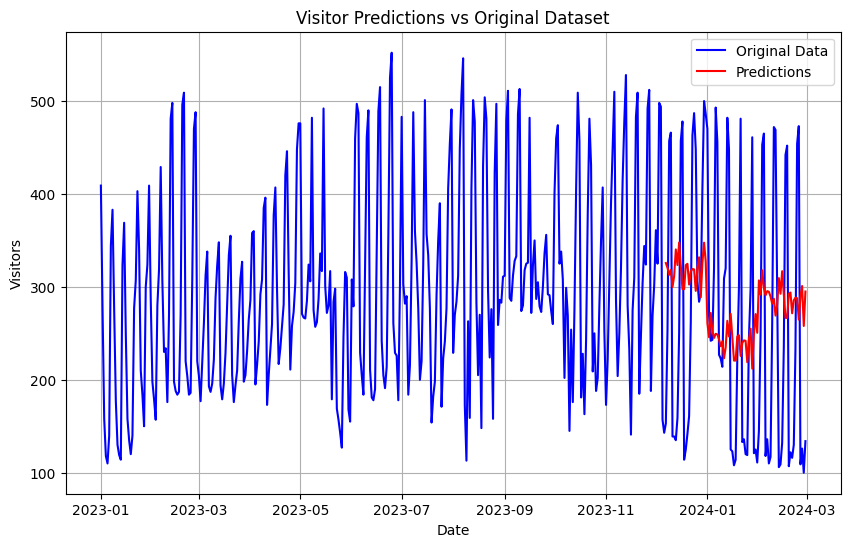

RMSE: 146.3896689190176


In [97]:
# Extract features
df_synthetic['year'] = df_synthetic.index.year
df_synthetic['month'] = df_synthetic.index.month
df_synthetic['day'] = df_synthetic.index.day

# Drop the day_of_week column, as we'll use it for prediction
features = ['year', 'month', 'day']
X = df_synthetic[features]
y = df_synthetic['visitors']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train,y_train)

# Make predictions
y_pred = xg_reg.predict(X_test)
y_pred

# Plot original dataset
plt.figure(figsize=(10, 6))
plt.plot(df_synthetic.index, df_synthetic['visitors'], label='Original Data', color='blue')

# Plot predictions
plt.plot(X_test.index, y_pred, label='Predictions', color='red')

plt.title('Visitor Predictions vs Original Dataset')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

## Feature Engineering

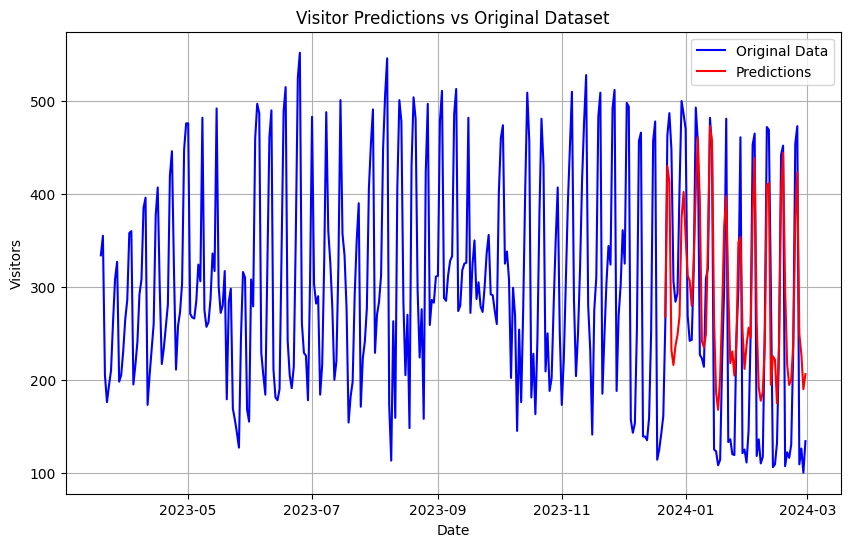

RMSE: 87.47446110409854
Cross-validation RMSE scores: [86.46568578 68.79432019 62.83339373 88.48572637 96.60256179]
Mean RMSE: 80.63633757160756


In [92]:
# Extract features
df_synthetic['year'] = df_synthetic.index.year
df_synthetic['month'] = df_synthetic.index.month
df_synthetic['day'] = df_synthetic.index.day
df_synthetic['day_of_week'] = df_synthetic.index.dayofweek

# Adding Lag Features
for i in range(1, 8):
    df_synthetic[f'lag_{i}'] = df_synthetic['visitors'].shift(i)

# Adding Rolling Statistics
rolling_window = 7  # 7-day rolling window
df_synthetic['rolling_mean'] = df_synthetic['visitors'].rolling(window=rolling_window).mean()
df_synthetic['rolling_std'] = df_synthetic['visitors'].rolling(window=rolling_window).std()

# Drop missing values created by lag and rolling window
df_synthetic.dropna(inplace=True)

# Drop the day_of_week column, as we'll use it for prediction
features = ['year', 'month', 'day', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'rolling_std']
X = df_synthetic[features]
y = df_synthetic['visitors']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred = xg_reg.predict(X_test)

# Plot original dataset
plt.figure(figsize=(10, 6))
plt.plot(df_synthetic.index, df_synthetic['visitors'], label='Original Data', color='blue')

# Plot predictions
plt.plot(X_test.index, y_pred, label='Predictions', color='red')

plt.title('Visitor Predictions vs Original Dataset')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
cv_scores = cross_val_score(xg_reg, X, y, cv=tscv, scoring='neg_mean_squared_error')

# Convert scores to RMSE
cv_rmse_scores = np.sqrt(-cv_scores)

# Print cross-validation scores
print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

##  hyperparameter tuning using grid search with cross-validation

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE: 38.67821363761566


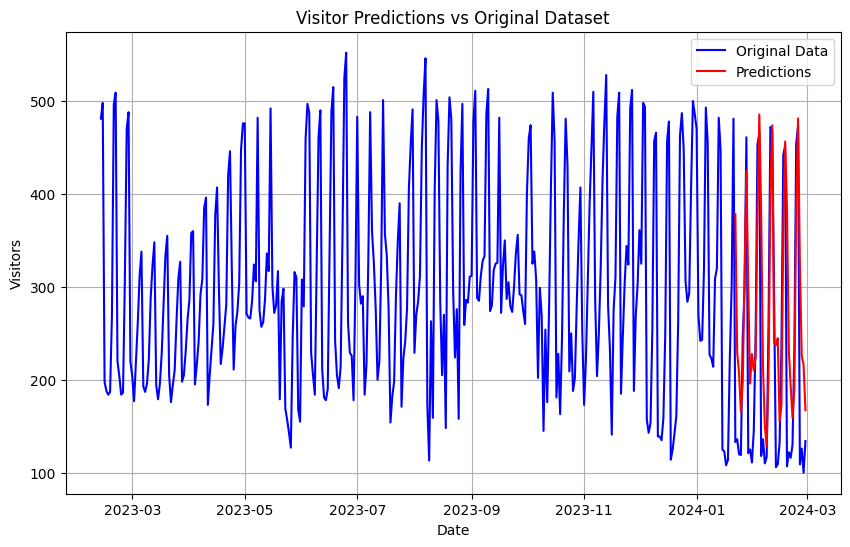

In [107]:
# Extract features
df_synthetic['year'] = df_synthetic.index.year
df_synthetic['month'] = df_synthetic.index.month
df_synthetic['day'] = df_synthetic.index.day
df_synthetic['day_of_week'] = df_synthetic.index.dayofweek

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Adding Lag Features
for i in range(1, 8):
    df_synthetic[f'lag_{i}'] = df_synthetic['visitors'].shift(i)

# Adding Rolling Statistics
rolling_window = 7  # 7-day rolling window
df_synthetic['rolling_mean'] = df_synthetic['visitors'].rolling(window=rolling_window).mean()
df_synthetic['rolling_std'] = df_synthetic['visitors'].rolling(window=rolling_window).std()

# Drop missing values created by lag and rolling window
df_synthetic.dropna(inplace=True)

# Drop the day_of_week column, as we'll use it for prediction
features = ['year', 'month', 'day', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean', 'rolling_std']
X = df_synthetic[features]
y = df_synthetic['visitors']

# Initialize XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize grid search with cross-validation using only the training data
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:", best_params)

# Make predictions using the best estimator
y_pred = best_estimator.predict(X)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

# Plot original dataset
plt.figure(figsize=(10, 6))
plt.plot(df_synthetic.index, df_synthetic['visitors'], label='Original Data', color='blue')

# Plot predictions against the test set
plt.plot(df_synthetic.index[-len(y_test):], y_pred[-len(y_test):], label='Predictions', color='red')

plt.title('Visitor Predictions vs Original Dataset')
plt.xlabel('Date')
plt.ylabel('Visitors')
plt.legend()
plt.grid(True)
plt.show()


Forecasting demand for a restaurant is crucial for effective inventory management, staff scheduling, and overall operational efficiency. Time series forecasting methods can help predict future demand based on historical data. 

We aim to apply various machine learning methods in this task and then identify the most suitable approach. Each method has its strengths and weaknesses, and the choice depends on factors such as data characteristics, level of accuracy required, computational resources, and ease of implementation. Experimenting with multiple methods and evaluating their performance using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) can help identify the most suitable approach for forecasting restaurant demand.

Methods include:
1. Autoregressive Integrated Moving Average (ARIMA)
2. Extreme Gradient Boosting (XGBoost)
3. Random Forest
(to be finalized)

#### ARIMA Model

In [6]:
#import necessary libraries
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df_synthetic = pd.read_csv("../data/raw/synthetic_visit_data.csv")
df_synthetic.head()


,day_of_week,visit_date,visitors
0,Sunday,2023-01-01,400
1,Monday,2023-01-02,280
2,Tuesday,2023-01-03,150
3,Wednesday,2023-01-04,120
4,Thursday,2023-01-05,110


In [10]:
df_synthetic_hourly = pd.read_csv("../data/raw/synthetic_visit_hourly_data.csv")
df_synthetic_hourly.head()

,day_of_week,visit_date,visitors_daily_total,hour_interval,visitors_hourly
0,Sunday,2023-01-01,409,10-11,0
1,Sunday,2023-01-01,409,11-12,13
2,Sunday,2023-01-01,409,12-13,65
3,Sunday,2023-01-01,409,13-14,67
4,Sunday,2023-01-01,409,14-15,17
